https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2023/04-deployment/homework.md

In this homework, we'll deploy the ride duration model in batch mode. Like in homework 1, we'll use the Yellow Taxi Trip Records dataset.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pickle

## Q1. Notebook

We'll start with the same notebook we ended up with in homework 1.
We cleaned it a little bit and kept only the scoring part. You can find the initial notebook [here](homework/starter.ipynb).

Run this notebook for the February 2022 data.

What's the standard deviation of the predicted duration for this dataset?

In [2]:
with open('model.bin', 'rb') as f_in:
    dv, model = pickle.load(f_in)

In [3]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df['duration'] = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].fillna(-1).astype('int').astype('str')
    
    return df

In [4]:
df = read_data('../../data/yellow_tripdata_2022-02.parquet')
print(df.shape)
df.head()

(2918187, 20)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,1,2022-02-01 00:06:58,2022-02-01 00:19:24,1.0,5.40,1.0,N,138,252,1,17.0,1.75,0.5,3.90,0.00,0.3,23.45,0.0,1.25,12.433333
1,1,2022-02-01 00:38:22,2022-02-01 00:55:55,1.0,6.40,1.0,N,138,41,2,21.0,1.75,0.5,0.00,6.55,0.3,30.10,0.0,1.25,17.550000
2,1,2022-02-01 00:03:20,2022-02-01 00:26:59,1.0,12.50,1.0,N,138,200,2,35.5,1.75,0.5,0.00,6.55,0.3,44.60,0.0,1.25,23.650000
3,2,2022-02-01 00:08:00,2022-02-01 00:28:05,1.0,9.88,1.0,N,239,200,2,28.0,0.50,0.5,0.00,3.00,0.3,34.80,2.5,0.00,20.083333
4,2,2022-02-01 00:06:48,2022-02-01 00:33:07,1.0,12.16,1.0,N,138,125,1,35.5,0.50,0.5,8.11,0.00,0.3,48.66,2.5,1.25,26.316667


In [5]:
dicts = df[categorical].to_dict(orient='records')
X_val = dv.transform(dicts)
y_pred = model.predict(X_val)

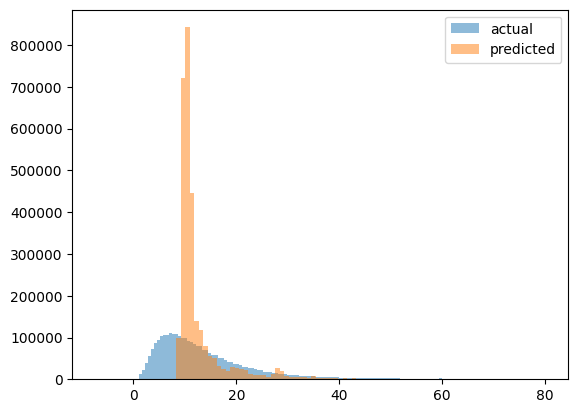

In [18]:
plt.hist(df.duration, bins=100, alpha=0.5, label='actual')
plt.hist(y_pred, bins=100, alpha=0.5, label='predicted')
plt.legend();

In [22]:
np.std(y_pred)

5.28140357655334

Answer: __5.28__

## Q2. Preparing the output

Like in the course videos, we want to prepare the dataframe with the output. 

First, let's create an artificial `ride_id` column:

```python
df['ride_id'] = f'{year:04d}/{month:02d}_' + df.index.astype('str')
```

Next, write the ride id and the predictions to a dataframe with results. 

Save it as parquet:

```python
df_result.to_parquet(
    output_file,
    engine='pyarrow',
    compression=None,
    index=False
)
```

What's the size of the output file?

In [23]:
year = 2022
month = 2
df['ride_id'] = f'{year:04d}/{month:02d}_' + df.index.astype('str')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration,ride_id
0,1,2022-02-01 00:06:58,2022-02-01 00:19:24,1.0,5.40,1.0,N,138,252,1,...,1.75,0.5,3.90,0.00,0.3,23.45,0.0,1.25,12.433333,2022/02_0
1,1,2022-02-01 00:38:22,2022-02-01 00:55:55,1.0,6.40,1.0,N,138,41,2,...,1.75,0.5,0.00,6.55,0.3,30.10,0.0,1.25,17.550000,2022/02_1
2,1,2022-02-01 00:03:20,2022-02-01 00:26:59,1.0,12.50,1.0,N,138,200,2,...,1.75,0.5,0.00,6.55,0.3,44.60,0.0,1.25,23.650000,2022/02_2
3,2,2022-02-01 00:08:00,2022-02-01 00:28:05,1.0,9.88,1.0,N,239,200,2,...,0.50,0.5,0.00,3.00,0.3,34.80,2.5,0.00,20.083333,2022/02_3
4,2,2022-02-01 00:06:48,2022-02-01 00:33:07,1.0,12.16,1.0,N,138,125,1,...,0.50,0.5,8.11,0.00,0.3,48.66,2.5,1.25,26.316667,2022/02_4


In [28]:
df_result = df[['ride_id']].copy()
df_result['predicted_duration'] = y_pred
df_result.head()

,ride_id,predicted_duration
0,2022/02_0,18.527783
1,2022/02_1,23.065782
2,2022/02_2,33.686359
3,2022/02_3,23.757436
4,2022/02_4,21.492904


In [34]:
output_file = f'yellow_tripdata_{year:04d}-{month:02d}.parquet'
df_result.to_parquet(
    output_file,
    engine='pyarrow',
    compression=None,
    index=False
)

In [42]:
!ls -lh {output_file}

-rwxrwxrwx 1 wsl wsl 58M Jun 18 22:31 yellow_tripdata_2022-02.parquet


Answer: __58 Mb__

## Q3. Creating the scoring script

Now let's turn the notebook into a script. 

Which command you need to execute for that?

In [44]:
!jupyter nbconvert --to script starter.ipynb

[NbConvertApp] Converting notebook starter.ipynb to script
[NbConvertApp] Writing 996 bytes to starter.py


Answer: __jupyter nbconvert --to script starter.ipynb__

## Q4. Virtual environment

Now let's put everything into a virtual environment. We'll use pipenv for that.

Install all the required libraries. Pay attention to the Scikit-Learn version:
it should be `scikit-learn==1.2.2`. 

After installing the libraries, pipenv creates two files: `Pipfile`
and `Pipfile.lock`. The `Pipfile.lock` file keeps the hashes of the
dependencies we use for the virtual env.

What's the first hash for the Scikit-Learn dependency?

`pipenv install scikit-learn==1.2.2 pandas --python=3.9`

In [45]:
!grep "scikit-learn" -A 5 Pipfile.lock

        "scikit-learn": {
            "hashes": [
                "sha256:065e9673e24e0dc5113e2dd2b4ca30c9d8aa2fa90f4c0597241c93b63130d233",
                "sha256:2dd3ffd3950e3d6c0c0ef9033a9b9b32d910c61bd06cb8206303fb4514b88a49",
                "sha256:2e2642baa0ad1e8f8188917423dd73994bf25429f8893ddbe115be3ca3183584",
                "sha256:44b47a305190c28dd8dd73fc9445f802b6ea716669cfc22ab1eb97b335d238b1",


Answer: __sha256:065e9673e24e0dc5113e2dd2b4ca30c9d8aa2fa90f4c0597241c93b63130d233__

## Q5. Parametrize the script

Let's now make the script configurable via CLI. We'll create two 
parameters: year and month.

Run the script for March 2022. 

What's the mean predicted duration? 

In [51]:
!python starter.py --year=2022 --month=3

Namespace(year='2022', month='3')
(3539827, 20)
y_pred: 12.76 +- 5.56


Answer: __12.76__

## Q6. Docker container 

Finally, we'll package the script in the docker container. 
For that, you'll need to use a base image that we prepared. 

This is how it looks like:

```
FROM python:3.10.0-slim

WORKDIR /app
COPY [ "model2.bin", "model.bin" ]
```

(see [`homework/Dockerfile`](homework/Dockerfile))

We pushed it to [`svizor/zoomcamp-model:mlops-3.10.0-slim`](https://hub.docker.com/layers/svizor/zoomcamp-model/mlops-3.10.0-slim/images/sha256-595bf690875f5b9075550b61c609be10f05e6915609ef4ea4ce9797116c99eff?context=repo),
which you should use as your base image.

That is, this is how your Dockerfile should start:

```docker
FROM svizor/zoomcamp-model:mlops-3.10.0-slim

# do stuff here
```

This image already has a pickle file with a dictionary vectorizer
and a model. You will need to use them.

Important: don't copy the model to the docker image. You will need
to use the pickle file already in the image. 

Now run the script with docker. What's the mean predicted duration
for April 2022? 

`docker build -t mlops_hw_4 .`

In [53]:
!docker run -it --rm mlops_hw_4

Namespace(year='2022', month='4')
reading: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-04.parquet
data size: (3501820, 20)
y_pred: 12.83 +- 5.45


Answer: __12.83__